In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np  
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pandas.plotting import parallel_coordinates
from scipy.cluster.hierarchy import linkage, dendrogram

In [2]:
data = 'dataset/df_data_engineered.csv'
index_col = 0
df = pd.read_csv(data, sep=',', index_col=index_col)

pd.set_option('display.max_columns', None)

In [3]:
df['gender'] = df['gender'].astype('category')
df['nationality'] = df['nationality'].astype('category')
df['country'] = df['country'].astype('category')
df['region'] = df['region'].astype('category')
df['province'] = df['province'].astype('category')
df['birth_place'] = df['birth_place'].astype('category')
df['birth_date'] = pd.to_datetime(df['birth_date'], errors='coerce')
df['active_start'] = pd.to_datetime(df['active_start'], errors='coerce')
df['description'] = df['description'].astype('string')


In [4]:
df['id_artist'] = df['id_artist'].astype('category')
df['id_album'] = df['id_album'].astype('category')
df['language'] = df['language'].astype('category')
df['album_type'] = df['album_type'].astype('category')
df['popularity'] = pd.to_numeric(df['popularity'], errors = 'coerce').astype('Int64')
df['n_sentences'] = df['n_sentences'].astype('Int64')
df['n_tokens'] = df['n_tokens'].astype('Int64')
df['disc_number'] = df['disc_number'].astype('Int64')
df['track_number'] = df['track_number'].astype('Int64')
df['explicit'] = df['explicit'].astype('bool')
df['has_featured_artist'] = df['has_featured_artist'].astype('bool')
df['name_artist'] = df['name_artist'].astype('string')
df['title'] = df['title'].astype('string')
df['album'] = df['album'].astype('string')
df['album_image'] = df['album_image'].astype('string')
df['lyrics'] = df['lyrics'].astype('string')
df['correct_release_date'] = pd.to_datetime(df['correct_release_date'], errors='coerce')

In [5]:
# 1. Definisci il Dizionario di Mappatura
# Mappa ogni regione (valore in df['region']) alla sua macro-regione
region_map = {
    'Valle d\'Aosta': 'Nord',
    'Piemonte': 'Nord',
    'Liguria': 'Nord',
    'Lombardia': 'Nord',
    'Trentino-Alto Adige': 'Nord',
    'Friuli-Venezia Giulia': 'Nord',
    'Veneto': 'Nord',
    'Emilia-Romagna': 'Nord',

    'Toscana': 'Center',
    'Umbria': 'Center',
    'Marche': 'Center',
    'Lazio': 'Center',

    'Abruzzo': 'South and Islands',
    'Molise': 'South and Islands',
    'Campania': 'South and Islands',
    'Puglia': 'South and Islands',
    'Basilicata': 'South and Islands',
    'Calabria': 'South and Islands',
    'Sicilia': 'South and Islands',
    'Sardegna': 'South and Islands',
}

# 2. Applica la Mappatura e crea la nuova colonna
# Usiamo .map() per creare la nuova colonna 'macro_region'
# Se un valore di 'region' non è presente nella mappa, verrà assegnato NaN.
df['macro_region'] = df['region'].map(region_map)

# 3. Trasforma la nuova colonna in tipo 'category'
df['macro_region'] = df['macro_region'].astype('category')

print("✅ La colonna 'macro_region' è stata creata e categorizzata.")
print("\nDistribuzione dei nuovi valori:")
print(df['macro_region'].value_counts(dropna=False))

✅ La colonna 'macro_region' è stata creata e categorizzata.

Distribuzione dei nuovi valori:
macro_region
Nord                 4368
NaN                  3142
South and Islands    2423
Center               1233
Name: count, dtype: int64


In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11166 entries, TR934808 to TR552777
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id_artist                      11166 non-null  category      
 1   name_artist                    11166 non-null  string        
 2   title                          11166 non-null  string        
 3   featured_artists               11166 non-null  object        
 4   language                       11032 non-null  category      
 5   swear_IT                       11166 non-null  int64         
 6   swear_EN                       11166 non-null  int64         
 7   swear_IT_words                 11166 non-null  object        
 8   swear_EN_words                 11166 non-null  object        
 9   n_sentences                    10959 non-null  Int64         
 10  n_tokens                       10955 non-null  Int64         
 11  tokens_per

In [178]:
df.describe()

swear_IT      swear_EN  n_sentences    n_tokens  tokens_per_sent  \
count  11166.000000  11166.000000      10959.0     10955.0     10958.000000   
mean       2.339244      0.710819    59.959303  500.932268         8.600413   
min        0.000000      0.000000          2.0         4.0         1.500000   
25%        0.000000      0.000000         46.0       377.0         7.363636   
50%        1.000000      0.000000         59.0       494.0         8.415650   
75%        3.000000      0.000000         73.0       617.0         9.434783   
max       72.000000     72.000000        295.0      1900.0        88.250000   
std        3.695084      2.555418    23.227734  195.235095         2.943498   

       char_per_tok  lexical_density  avg_token_per_clause           bpm  \
count  11090.000000     11081.000000          10945.000000  11101.000000   
mean       4.054416         0.514245              7.626489    114.078618   
min        2.000000         0.111732              0.000000     59.970000   
25%        3.866946         0.482353              5.883333     91.910000   
50%        4.012709         0.511719              6.776119    106.970000   
75%        4.168686         0.542416              8.096154    134.620000   
max       12.000000         0.942559            143.500000    191.410000   
std        0.445958         0.059994              5.370669     26.166049   

           centroid       rolloff          flux           rms      flatness  \
count  11087.000000  11095.000000  11087.000000  11094.000000  11093.000000   
mean       0.137479   1616.026913      1.259187      0.223766      0.860538   
min        0.040000    223.468300      0.754900      0.000000      0.201400   
25%        0.119200   1223.008750      1.172200      0.186200      0.841600   
50%        0.137200   1551.048700      1.257100      0.229700      0.882500   
75%        0.155100   1935.353550      1.346750      0.267500      0.913100   
max        0.239700   5476.346900      1.727800      0.427300      1.000000   
std        0.027820    559.446473      0.134068      0.064162      0.107410   

       spectral_complexity         pitch  disc_number  track_number  \
count         11098.000000  11097.000000      11088.0       11087.0   
mean             27.409474   2256.850787     1.016685      6.753044   
min               0.308300   1006.460600          1.0           1.0   
25%              21.884200   2003.515600          1.0           2.0   
50%              27.330850   2241.510600          1.0           5.0   
75%              32.976175   2493.629600          1.0          10.0   
max              54.434800   3993.020300          5.0          48.0   
std               8.424299    380.170700     0.138903      6.103532   

        duration_ms  popularity                     birth_date  \
count  1.108500e+04     11088.0                           8588   
mean   2.026591e+05   32.656295  1986-04-19 16:26:26.213320960   
min    1.142600e+04         0.0            1967-10-07 00:00:00   
25%    1.701250e+05        16.0            1979-10-21 00:00:00   
50%    1.966360e+05        32.0            1986-12-01 00:00:00   
75%    2.271790e+05        47.0            1993-02-11 00:00:00   
max    1.878254e+06       100.0            2002-04-29 00:00:00   
std    7.022926e+04   19.781473                            NaN   

                        active_start     latitude    longitude  \
count                          11166  8588.000000  8588.000000   
mean   2003-04-29 02:10:53.842020352    43.332645    11.352280   
min              1977-09-30 00:00:00    37.747452     7.525403   
25%              1996-01-01 00:00:00    40.996545     9.189635   
50%              2003-09-01 00:00:00    44.407260    10.985738   
75%              2011-01-01 00:00:00    45.464194    13.217949   
max              2022-05-27 00:00:00    45.806691    18.225226   
std                              NaN     2.318645     2.672280   

                correct_release_date  mean_popularity_artist  \
count   

In [360]:
# Select the final, cleaned, and engineered numerical features

# Select the final, cleaned, and engineered numerical features
FEATURE_COLS = [
    # Linguistic & Rate Features
    'tokens_per_sent', 'avg_token_per_clause', 'swear_rate', 'tokens_per_minute', 'n_sentences', 'n_tokens', 'swear_IT', 'swear_EN', 'lexical_density', 'char_per_tok',
    
    # Audio/Acoustic Features (Using a representative sample)
    'bpm', 'centroid', 'rolloff', 'flux', 'rms', 'spectral_complexity', 'pitch', 'flatness', 'duration_ms', 'mean_duration_song_per_album',
    
    # Aggregated/Relative Popularity Features
    'popularity', 'mean_popularity_artist',
    'rank_by_year',# 'latitude', 'longitude' 'song_pop_vs_region_avg_zscore' 'release_gap_zscore', 
]

#FEATURE_COLS = df.select_dtypes(include=np.number).columns

In [361]:
import numpy as np

# Use select_dtypes to filter columns that belong to a numeric data type
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()

print("Numeric Columns:")
print(numeric_columns)

Numeric Columns:
['swear_IT', 'swear_EN', 'n_sentences', 'n_tokens', 'tokens_per_sent', 'char_per_tok', 'lexical_density', 'avg_token_per_clause', 'bpm', 'centroid', 'rolloff', 'flux', 'rms', 'flatness', 'spectral_complexity', 'pitch', 'disc_number', 'track_number', 'duration_ms', 'popularity', 'latitude', 'longitude', 'mean_popularity_artist', 'mean_popularity_album', 'mean_duration_song_per_album', 'song_pop_vs_region_avg_zscore', 'release_gap_zscore', 'tokens_per_minute', 'swear_rate', 'rank_by_year', 'cluster_hc', 'Cluster']


plotting the distribution for attribute: id_artist, else branch (Categorical)


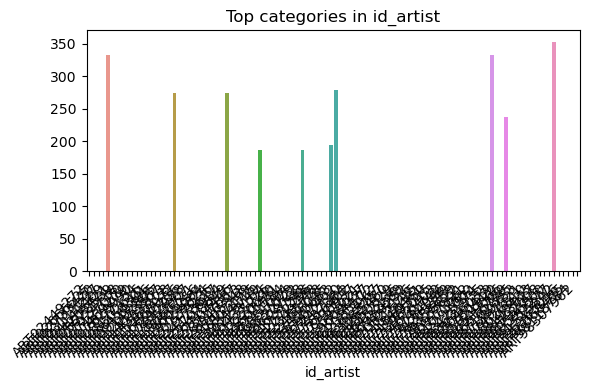

plotting the distribution for attribute: name_artist, else branch (Categorical)


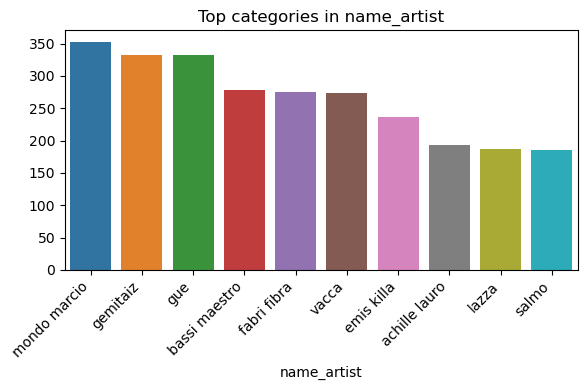

plotting the distribution for attribute: title, else branch (Categorical)


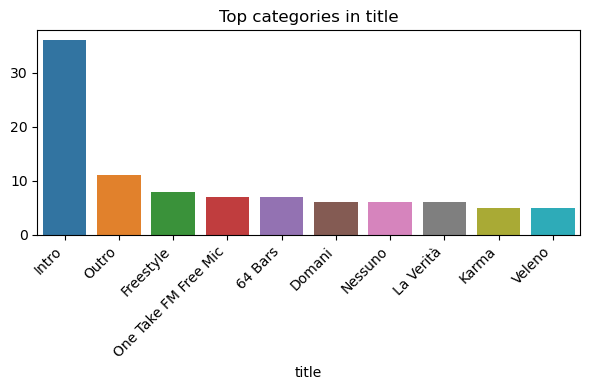

plotting the distribution for attribute: featured_artists, else branch (Categorical)


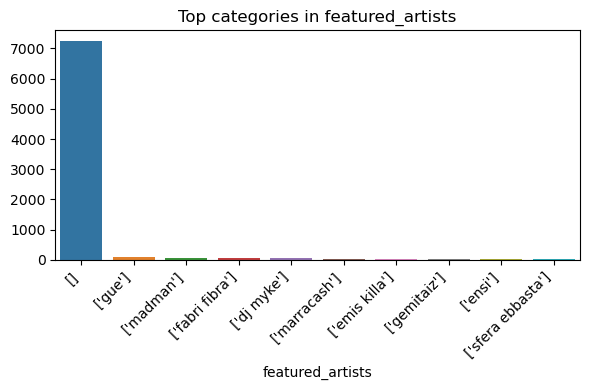

plotting the distribution for attribute: language, else branch (Categorical)


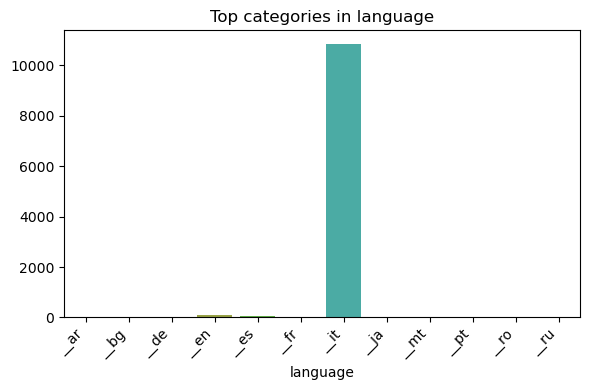

plotting the distribution for attribute: swear_IT, if branch (Numerical)


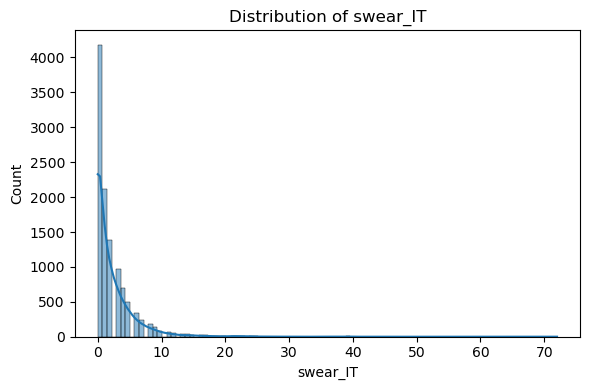

plotting the distribution for attribute: swear_EN, if branch (Numerical)


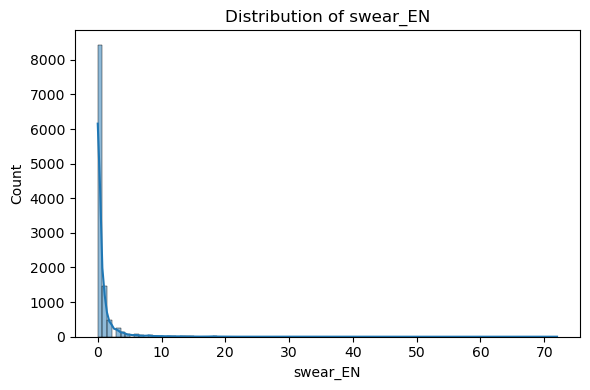

plotting the distribution for attribute: swear_IT_words, else branch (Categorical)


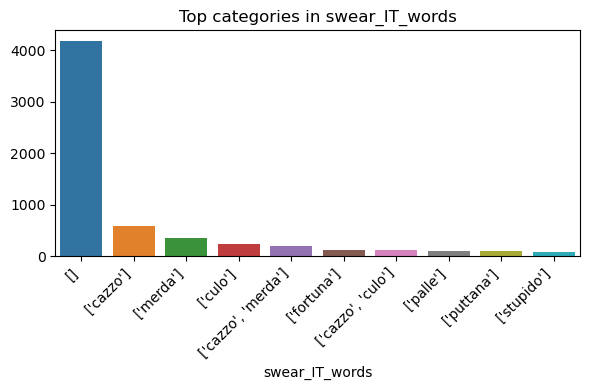

plotting the distribution for attribute: swear_EN_words, else branch (Categorical)


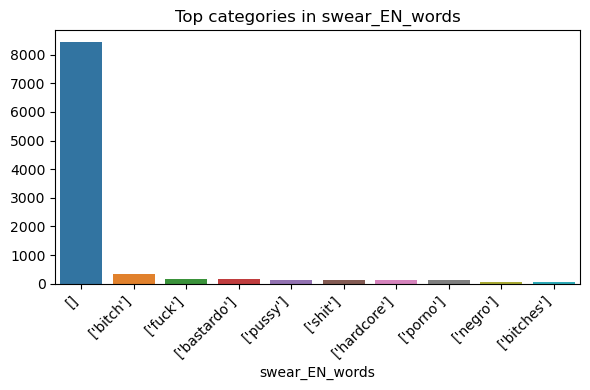

plotting the distribution for attribute: n_sentences, if branch (Numerical)



KeyboardInterrupt



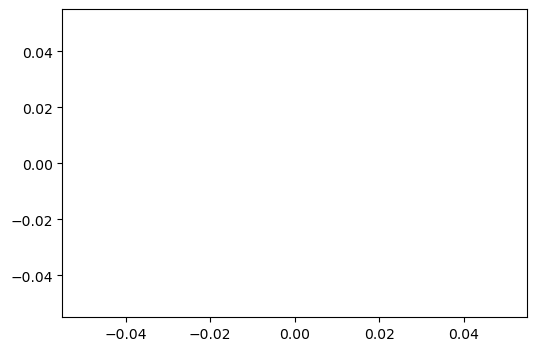

In [92]:
for col in df.columns:
    plt.figure(figsize=(6,4))
    
    # --- Check for Numerical Columns (includes float64, int64, and Nullable Int64) ---
    # Using .kind in 'fi' is a reliable way to check for all float and integer types
    if df[col].dtype.kind in 'fi': 
        print(f"plotting the distribution for attribute: {col}, if branch (Numerical)")
        
        data_to_plot = df[col].dropna()
            
        sns.histplot(data_to_plot, kde=True, bins = 100)
        plt.title(f'Distribution of {col}')

    # --- Handle Categorical/Object Columns, using try/except for unhashable types ---
    # We use a try/except to catch the 'unhashable type: list' error gracefully
    else:
        try:
            print(f"plotting the distribution for attribute: {col}, else branch (Categorical)")
            
            # The error occurs here if the column contains Python lists
            counts = df[col].value_counts().head(10)
            
            # Only proceed if there are values to plot
            if not counts.empty:
                sns.barplot(x=counts.index, y=counts.values)
                plt.title(f'Top categories in {col}')
                plt.xticks(rotation=45, ha='right')
            else:
                print(f"Skipping categorical plot for {col}: Value counts were empty.")

        except TypeError as e:
            # This handles the 'TypeError: unhashable type: 'list'' gracefully
            if 'unhashable type' in str(e):
                print(f"Skipping plot for {col}: Column contains unhashable types (e.g., Python lists).")
            else:
                # Re-raise any other unexpected TypeErrors
                raise e

    plt.tight_layout()
    plt.show()

In [362]:
# --- FEATURES TO LOG TRANSFORM ---
LOG_TRANSFORM_COLS = [
    'swear_IT', 'swear_EN', 'n_sentences', 'n_tokens', 'tokens_per_sent',
    'tokens_per_minute', 'duration_ms', 'popularity', 
    'mean_popularity_artist',
    'mean_duration_song_per_album', 'rolloff', 'release_gap_zscore',
     # Acoustic features often benefit from log or similar scaling
]
# --- IMPORTANT: Filter the DataFrame for clustering first ---
# Create a copy of the features you plan to use, dropping NaNs
# This ensures consistency and prevents modifying the original df unnecessarily.
data_for_clustering = df[FEATURE_COLS].copy().dropna()

# 1. Apply the log(x+1) transformation using numpy.log1p
for col in LOG_TRANSFORM_COLS:
    # Ensure the column exists in the data subset before transforming
    if col in data_for_clustering.columns:
        # np.log1p(x) calculates log(x + 1)
        data_for_clustering[col] = np.log1p(data_for_clustering[col])

print("✅ Log Transformation applied to selected features in 'data_for_clustering'.")
print("First 5 rows of transformed data (showing example changes):")
#print(data_for_clustering[['n_tokens', 'tokens_per_minute', 'popularity', 'rank_by_year']].head())

✅ Log Transformation applied to selected features in 'data_for_clustering'.
First 5 rows of transformed data (showing example changes):


In [363]:
print(f"Original rows: {len(df)}. Rows for clustering after dropping NaNs: {len(data_for_clustering)}")

Original rows: 11166. Rows for clustering after dropping NaNs: 10620


In [364]:
# Create the index mask for later mapping the clusters back to df
original_indices = data_for_clustering.index

# Initialize the scaler
scaler = MinMaxScaler()
#scaler = StandardScaler()

# Fit and transform the data
X_scaled = scaler.fit_transform(data_for_clustering.values)

In [270]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# 1. Train a simple Decision Tree to predict the Cluster ID
# We use the ORIGINAL (unscaled) data to make the rules readable (e.g., "BPM > 120")
X_debug = df[FEATURE_COLS].loc[original_indices] # Use your full feature list here
y_debug = df.loc[original_indices, 'cluster_hc'] # or 'cluster_kmeans'

# Max_depth=3 makes the tree simple enough to read
clf = DecisionTreeClassifier(max_depth=3, random_state=7)
clf.fit(X_debug, y_debug)

# 2. Visualize the Rules
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=FEATURE_COLS, class_names=['Clst 0', 'Clst 1', 'Clst 2', 'Clst 3'], filled=True, fontsize=10)
plt.title("What actually defines my clusters?")
plt.show()

# 3. Print Feature Importance
importance = pd.Series(clf.feature_importances_, index=FEATURE_COLS).sort_values(ascending=False)
print("Top 5 Features defining your clusters:")
print(importance.head(5))

ValueError: Input y contains NaN.

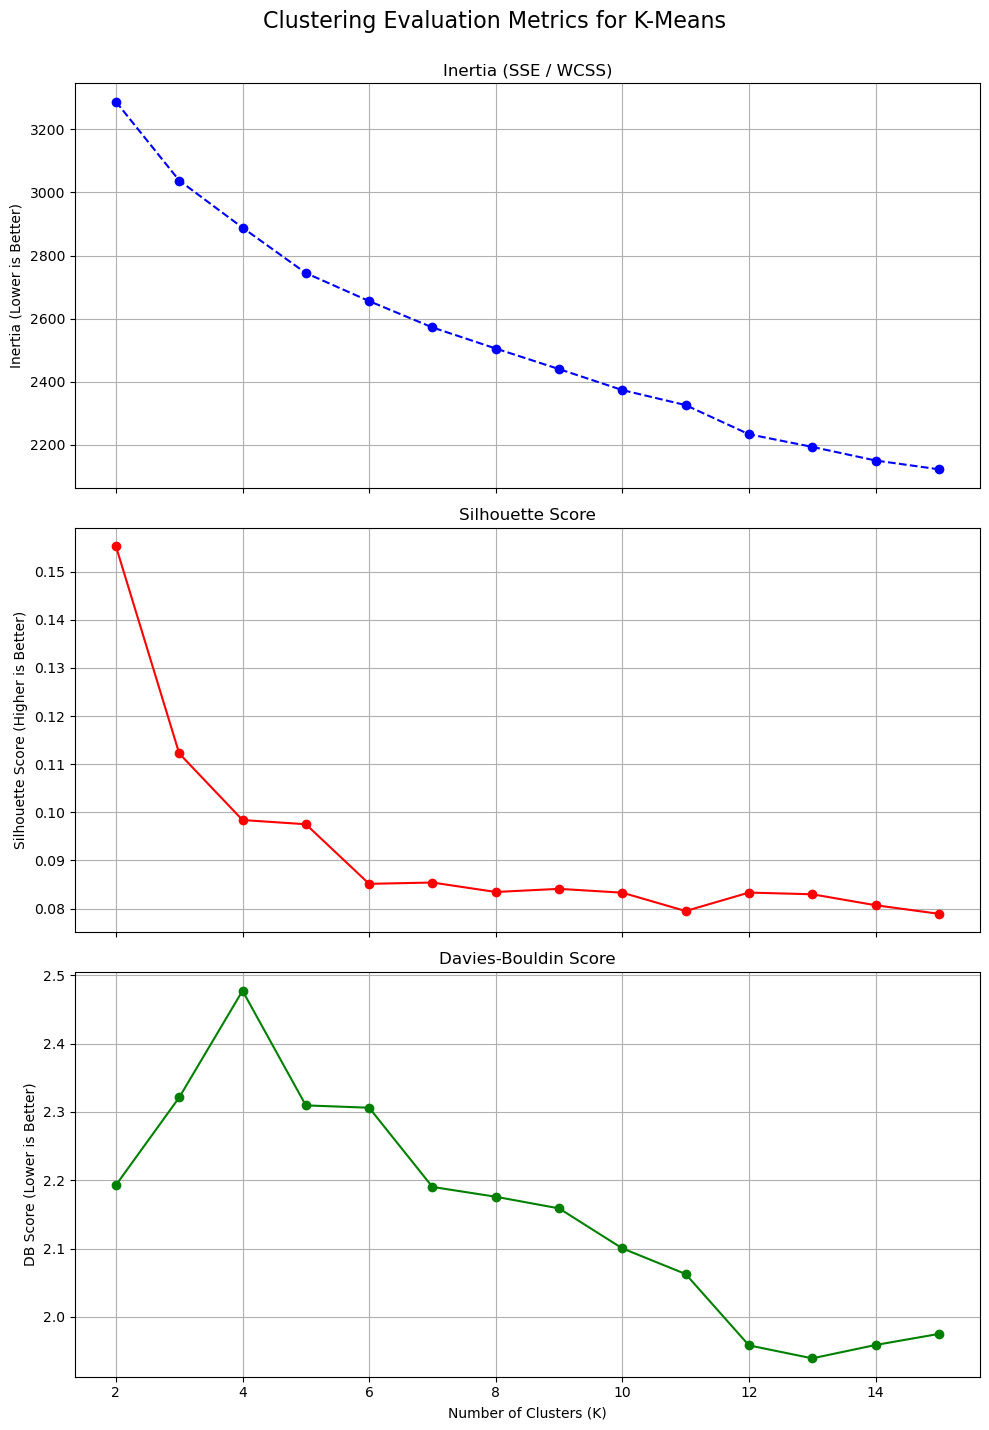

In [365]:
# --- Initialization ---
k_range = range(2, 16) 
inertia_values = []
silhouette_values = []
davies_bouldin_values = []

# --- Loop and Calculate Metrics ---

for k in k_range:
    # 1. Train K-Means
    # Using n_init='auto' is the modern standard, replacing n_init=10
    kmeans = KMeans(n_clusters=k, random_state=7, n_init='auto') 
    kmeans.fit(X_scaled)
    
    # Get the cluster labels for evaluation metrics
    labels = kmeans.labels_
    
    # 2. Calculate Inertia (WCSS / SSE)
    inertia_values.append(kmeans.inertia_)
    
    # 3. Calculate Silhouette Score (Requires K >= 2)
    # The score is calculated on the scaled data (X_scaled) and the labels
    silhouette_values.append(silhouette_score(X_scaled, labels))
    
    # 4. Calculate Davies-Bouldin Score (Requires K >= 2)
    davies_bouldin_values.append(davies_bouldin_score(X_scaled, labels))

# --- Plotting All Metrics ---

fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
fig.suptitle('Clustering Evaluation Metrics for K-Means', fontsize=16)

# 1. Inertia Plot (WCSS / SSE) - Lower is better (Elbow Method)
axes[0].plot(k_range, inertia_values, marker='o', linestyle='--', color='blue')
axes[0].set_title('Inertia (SSE / WCSS)')
axes[0].set_ylabel('Inertia (Lower is Better)')
axes[0].grid(True)

# 2. Silhouette Score Plot - Higher is better
axes[1].plot(k_range, silhouette_values, marker='o', linestyle='-', color='red')
axes[1].set_title('Silhouette Score')
axes[1].set_ylabel('Silhouette Score (Higher is Better)')
axes[1].grid(True)

# 3. Davies-Bouldin Score Plot - Lower is better
axes[2].plot(k_range, davies_bouldin_values, marker='o', linestyle='-', color='green')
axes[2].set_title('Davies-Bouldin Score')
axes[2].set_ylabel('DB Score (Lower is Better)')
axes[2].set_xlabel('Number of Clusters (K)')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent suptitle overlap
plt.show()

In [366]:
# --- STEP 4A: Train the final model ---
optimal_k =  4# Replace with the K you chose from the plot

kmeans_final = KMeans(n_clusters=optimal_k, random_state=7, n_init='auto')
kmeans_final.fit(X_scaled)

# --- STEP 4B: Assign the labels back to the original DataFrame ---

# Create a temporary Series with the cluster labels and the corresponding index
cluster_labels_series = pd.Series(kmeans_final.labels_, index=original_indices)

# Assign the labels back to the main DataFrame
df['Cluster'] = np.nan # Initialize the column with NaN
df.loc[original_indices, 'Cluster'] = cluster_labels_series

# Convert the Cluster column to a category or Int64
df['Cluster'] = df['Cluster'].astype('Int64')

print(f"\n✅ Clustering complete! Data is grouped into {optimal_k} clusters.")
print(df['Cluster'].value_counts(dropna=False))


✅ Clustering complete! Data is grouped into 4 clusters.
Cluster
3       3397
0       2747
1       2606
2       1870
<NA>     546
Name: count, dtype: Int64


In [367]:
print('SSE %s' % kmeans_final.inertia_) # cohesion, lower value better clustering (error minimization)
print('Separation %s' % davies_bouldin_score(X_scaled, kmeans_final.labels_)) # lower value, better clustering (minimum zero)
print('Silhouette %s' % silhouette_score(X_scaled, kmeans_final.labels_))

SSE 2888.367943423807
Separation 2.4772151579534345
Silhouette 0.09838526453733636


In [368]:
# Analyze the cluster centroids using the original feature names
cluster_profiles = df.groupby('Cluster')[FEATURE_COLS].mean()

print("\n--- Cluster Profile Analysis (Mean Feature Values) ---")
print(cluster_profiles.T)


--- Cluster Profile Analysis (Mean Feature Values) ---
Cluster                                   0              1              2  \
tokens_per_sent                    9.040663        8.36743       8.655511   
avg_token_per_clause               7.738008          7.451       7.724521   
swear_rate                         0.011922       0.005598       0.004939   
tokens_per_minute                188.201137     157.712978     126.483484   
n_sentences                       69.549327      64.439371      50.077005   
n_tokens                         611.824172     527.080967     407.103209   
swear_IT                           5.280306       2.340368       1.510695   
swear_EN                           1.587914       0.552187       0.413904   
lexical_density                    0.523646       0.511805       0.505038   
char_per_tok                       4.016695       4.021071       4.058575   
bpm                              112.149789     113.621201     111.748267   
centroid            

In [369]:
scaled_centroids = kmeans_final.cluster_centers_

# 3. Convert the NumPy array of scaled centroids into a DataFrame
scaled_cluster_profiles = pd.DataFrame(
    scaled_centroids,
    columns=FEATURE_COLS # Use the original feature names
)

# 4. Add the 'Cluster' ID column
scaled_cluster_profiles['Cluster'] = scaled_cluster_profiles.index.values.astype(int)

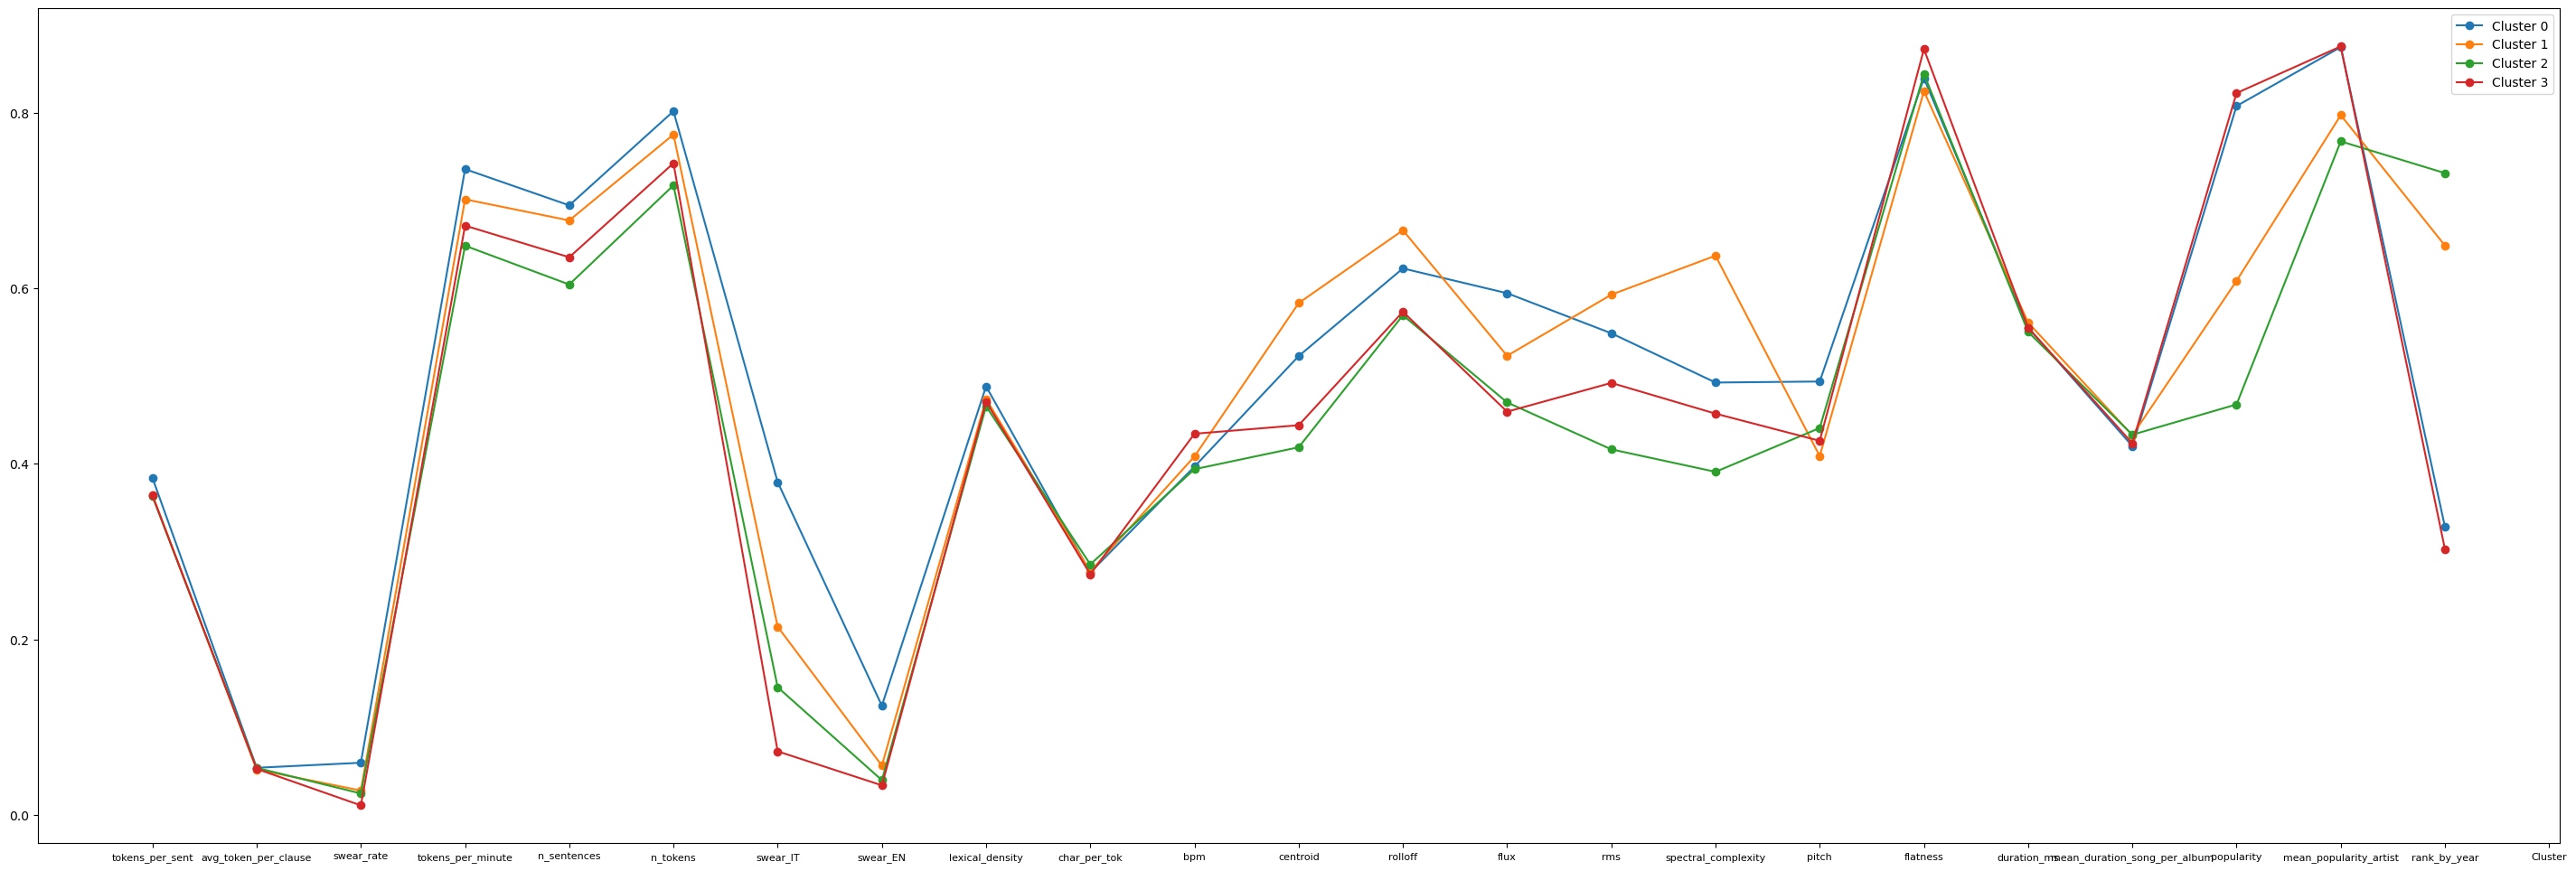

In [370]:
plt.figure(figsize=(36, 12))
for i in range(0, len(scaled_centroids)):
    plt.plot(scaled_centroids[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(scaled_cluster_profiles.columns)), scaled_cluster_profiles.columns, fontsize=8)
plt.legend(fontsize=10)
plt.show()

In [371]:
# 1. Get the scaled data and the corresponding cluster labels
# Assuming X_scaled contains your scaled features and 'Cluster' is assigned to df

# Drop rows where cluster assignment failed (due to missing values in the original features)
clustered_df = df.dropna(subset=['Cluster']).copy()
X_scaled_clustered = MinMaxScaler().fit_transform(clustered_df[FEATURE_COLS])
cluster_labels = clustered_df['Cluster'].astype(int) # Ensure labels are integer

# 2. Initialize and run PCA to reduce the data to 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled_clustered)

# 3. Create a DataFrame for plotting
pca_df = pd.DataFrame(
    data=principal_components, 
    columns=['PC1', 'PC2']
)

# Add the cluster labels back to the plotting DataFrame
pca_df['Cluster'] = cluster_labels.values

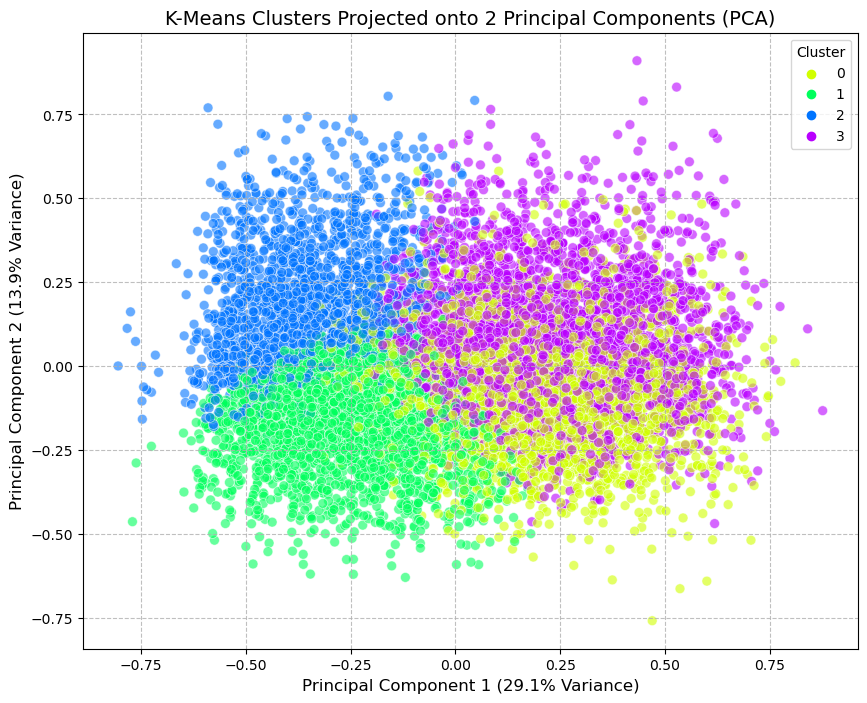

In [372]:
plt.figure(figsize=(10, 8))

# Use seaborn scatterplot, coloring points by the 'Cluster' column
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='Cluster', 
    data=pca_df,
    palette=sns.color_palette("hsv", n_colors=pca_df['Cluster'].nunique()), # Use distinct colors
    legend="full",
    alpha=0.6,
    s=50
)

plt.title('K-Means Clusters Projected onto 2 Principal Components (PCA)', fontsize=14)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% Variance)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% Variance)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.8)
plt.show()

In [373]:
# Assuming 'pca_df' (with columns PC1, PC2, Cluster) is available from your PCA step.

# Group data to find the centroid (mean) and standard deviation (std) for each cluster
cluster_stats = pca_df.groupby('Cluster')[['PC1', 'PC2']].agg(['mean', 'std']).fillna(0) # fillna handles single-point clusters

# Extract Centroids
centroids = cluster_stats.loc[:, 'PC1']['mean'].values
centroid_df = cluster_stats.loc[:, (slice(None), 'mean')]
centroid_df.columns = centroid_df.columns.droplevel(1) # Drop the 'mean' level

# Extract Standard Deviations
std_devs = cluster_stats.loc[:, (slice(None), 'std')]
std_devs.columns = std_devs.columns.droplevel(1) # Drop the 'std' level

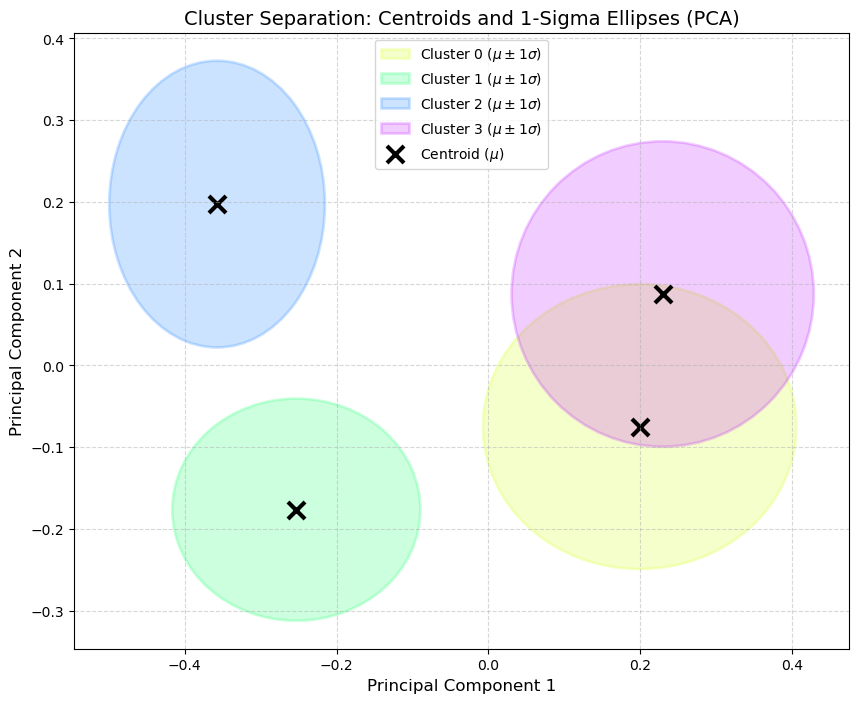

In [374]:
fig, ax = plt.subplots(figsize=(10, 8))

# Get the color palette used for the clusters
num_clusters = pca_df['Cluster'].nunique()
palette = sns.color_palette("hsv", n_colors=num_clusters)

# Plot the Ellipses (1 Standard Deviation boundary)
for cluster_id in range(num_clusters):
    # Get centroid coordinates and std dev for the current cluster
    center = (centroid_df.loc[cluster_id, 'PC1'], centroid_df.loc[cluster_id, 'PC2'])
    std_pc1 = std_devs.loc[cluster_id, 'PC1']
    std_pc2 = std_devs.loc[cluster_id, 'PC2']
    color = palette[cluster_id]

    # Create the ellipse object
    # The width is 2*std_pc1, and height is 2*std_pc2 to cover +/- 1 standard deviation
    ellipse = patches.Ellipse(
        center, 
        width=2*std_pc1, 
        height=2*std_pc2,
        angle=0, # Assuming PC axes are orthogonal
        edgecolor=color, 
        facecolor=color,
        alpha=0.2, # Make the ellipse transparent
        linewidth=2,
        label=f'Cluster {cluster_id} ($\mu \pm 1\sigma$)'
    )
    ax.add_patch(ellipse)

# Plot the Centroids on top
ax.scatter(
    centroid_df['PC1'], 
    centroid_df['PC2'], 
    color='black', 
    marker='x', 
    s=150, 
    linewidths=3,
    label='Centroid ($\mu$)'
)

# Set plot details
ax.set_title('Cluster Separation: Centroids and 1-Sigma Ellipses (PCA)', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=12)
ax.set_ylabel('Principal Component 2', fontsize=12)

# Ensure the plot limits show all ellipses
ax.autoscale_view()
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.show()

In [325]:
categorical_columns = df.select_dtypes(include=['category']).columns.tolist()

print("Categorical Columns:")
print(categorical_columns)

Categorical Columns:
['id_artist', 'language', 'album_type', 'id_album', 'gender', 'birth_place', 'nationality', 'province', 'region', 'country', 'macro_region']


In [326]:
# Example: Analyzing the 'explicit' (binary) and 'region' (categorical) columns



EXTERNAL_CATEGORICAL_COLS = ['language', 'album_type', 'gender', 'birth_place', 'nationality', 'province', 'region', 'country', 'explicit', 'has_featured_artist','Artist_Generation','macro_region',]

for col in EXTERNAL_CATEGORICAL_COLS:
    # 1. Calculate the raw counts
    cross_tab = pd.crosstab(df['Cluster'], df[col])
    
    # 2. Convert counts to proportions (percentage of the cluster)
    proportions = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
    
    print(f"\n--- PROPORTIONS OF {col.upper()} BY CLUSTER ---")
    print(proportions.round(1))


--- PROPORTIONS OF LANGUAGE BY CLUSTER ---
language  __ar  __de  __en  __es  __fr  __it  __ja  __mt  __pt  __ro
Cluster                                                             
0          0.0   0.0   0.1   0.1   0.0  99.7   0.0   0.0   0.0   0.0
1          0.0   0.0   1.1   0.4   0.0  98.4   0.0   0.0   0.1   0.0
2          0.0   0.1   0.9   0.9   0.2  97.9   0.0   0.0   0.0   0.1
3          0.0   0.2   2.3   0.1   0.2  97.0   0.1   0.0   0.0   0.0

--- PROPORTIONS OF ALBUM_TYPE BY CLUSTER ---
album_type  album  compilation  single
Cluster                               
0            87.7          1.5    10.8
1            80.5          2.7    16.8
2            85.8          1.0    13.1
3            82.7          0.8    16.5

--- PROPORTIONS OF GENDER BY CLUSTER ---
gender     F     M
Cluster           
0        1.9  98.1
1        6.8  93.2
2        6.0  94.0
3        6.7  93.3

--- PROPORTIONS OF BIRTH_PLACE BY CLUSTER ---
birth_place  Almería  Alpignano  Avellino  Bologna  Brescia

In [328]:
tsne = TSNE(n_components=2, perplexity=30, random_state=7, n_jobs=-1)
tsne_components = tsne.fit_transform(X_scaled_clustered)

# 4. Create a DataFrame for plotting
tsne_df = pd.DataFrame(
    data=tsne_components, 
    columns=['TSNE_Component_1', 'TSNE_Component_2']
)

# Add the cluster labels back
tsne_df['Cluster'] = cluster_labels.values

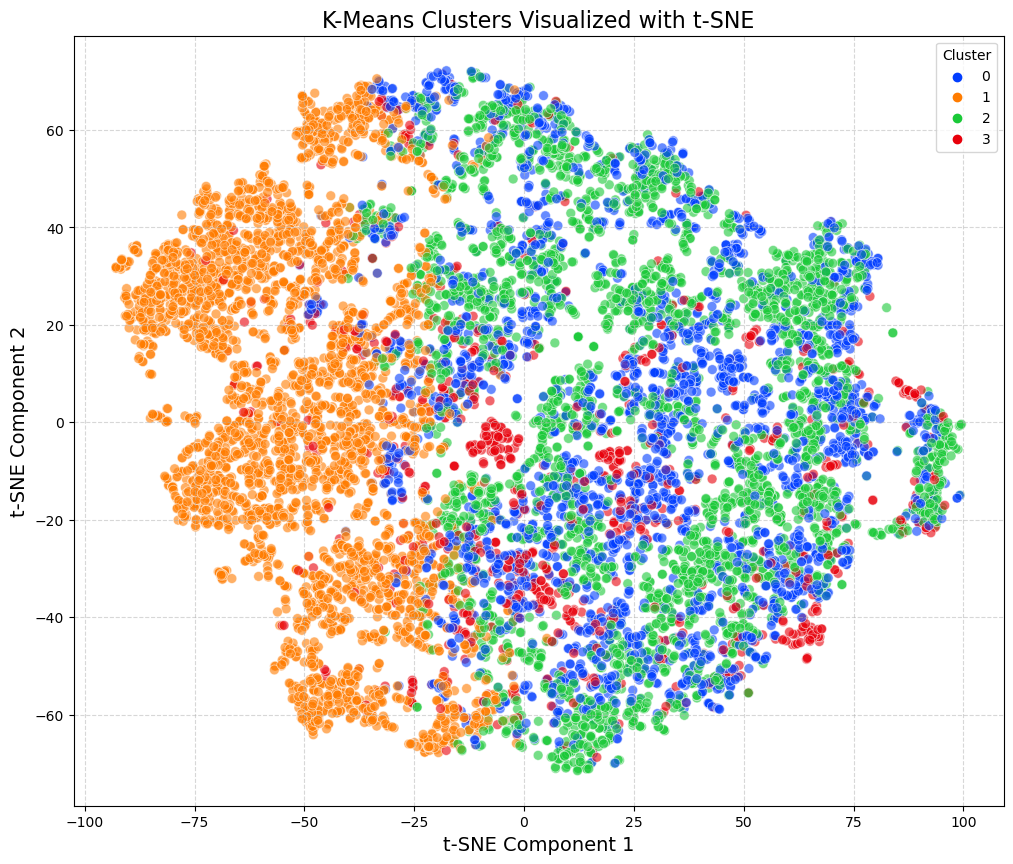

In [329]:
plt.figure(figsize=(12, 10))

# Use seaborn scatterplot, coloring points by the 'Cluster' column
sns.scatterplot(
    x='TSNE_Component_1', 
    y='TSNE_Component_2', 
    hue='Cluster', 
    data=tsne_df,
    palette=sns.color_palette("bright", n_colors=tsne_df['Cluster'].nunique()), 
    legend="full",
    alpha=0.6,
    s=50
)

plt.title('K-Means Clusters Visualized with t-SNE', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

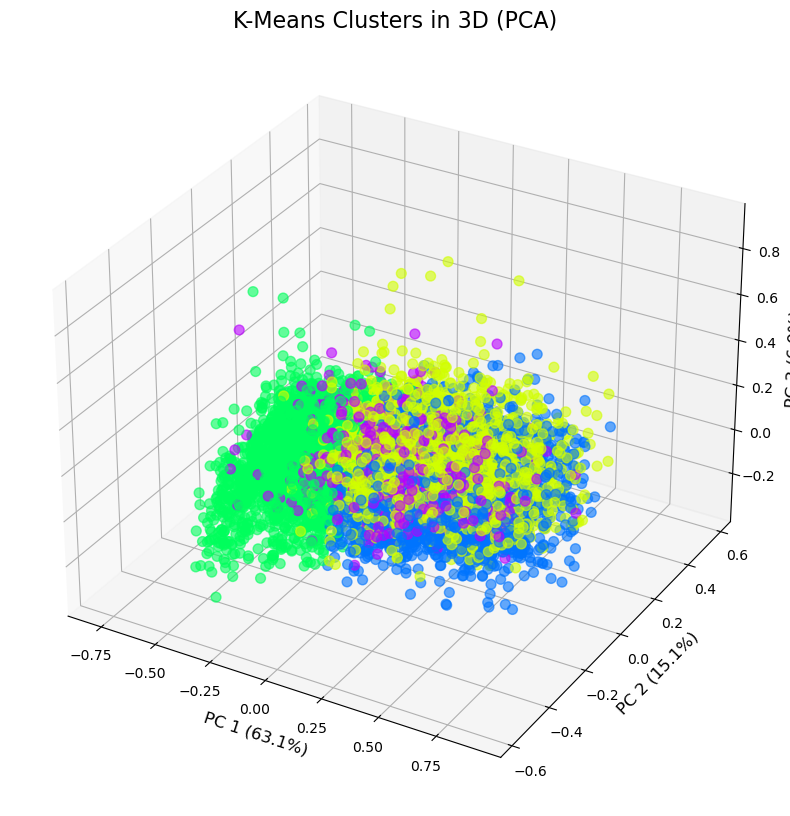

In [330]:
# 1. Run PCA for 3 components
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_scaled_clustered)

# 2. Create DataFrame for plotting
pca_df = pd.DataFrame(
    data=principal_components, 
    columns=['PC1', 'PC2', 'PC3']
)
pca_df['Cluster'] = cluster_labels.values


# 3. 3D Plotting
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Get distinct colors
num_clusters = pca_df['Cluster'].nunique()
palette = sns.color_palette("hsv", n_colors=num_clusters)
colors = [palette[c] for c in pca_df['Cluster']]

# Scatter plot
ax.scatter(
    pca_df['PC1'], 
    pca_df['PC2'], 
    pca_df['PC3'], 
    c=colors, 
    marker='o', 
    s=50,
    alpha=0.6
)

# Set labels with explained variance
ax.set_title('K-Means Clusters in 3D (PCA)', fontsize=16)
ax.set_xlabel(f'PC 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax.set_ylabel(f'PC 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
ax.set_zlabel(f'PC 3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=12)

plt.show()

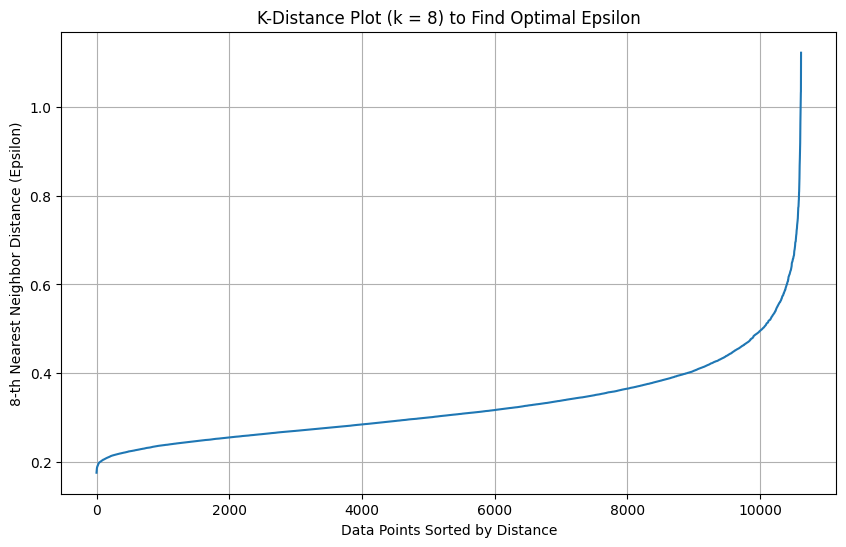

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

# --- Re-run the scaling step (assuming X_scaled is ready) ---
# X_scaled = ... (Your previously calculated scaled data, which includes log transformation)
# FEATURE_COLS = data_for_clustering.columns.tolist()

# 1. Set k (min_samples)
# k = 2 * len(FEATURE_COLS)
# if k < 4:
#     k = 4 # k must be at least 4 for robust estimation

k = 8

# 2. Calculate the distance to the k-th nearest neighbor for every point
# The 'NearestNeighbors' tool uses k-1 neighbors because the point itself is the 0th neighbor.
# We set n_neighbors = k (which is min_samples)
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X_scaled)

# distances contains the distances to all neighbors (including itself)
# indices contains the indices of those neighbors
distances, indices = nn.kneighbors(X_scaled)

# 3. Sort the distances to the k-th neighbor (the last column of the distance matrix)
# We sort them to create the elbow plot.
distances = np.sort(distances[:, k-1], axis=0)

# 4. Plot the K-Distance Graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title(f'K-Distance Plot (k = {k}) to Find Optimal Epsilon')
plt.xlabel('Data Points Sorted by Distance')
plt.ylabel(f'{k}-th Nearest Neighbor Distance (Epsilon)')
plt.grid(True)
plt.show()
#

In [ ]:
from sklearn.cluster import DBSCAN

# --- Input the values you determined from the plot ---
# k is min_samples
MIN_SAMPLES = k 
EPSILON = 0.5 # <--- REPLACE WITH THE VALUE FOUND ON THE Y-AXIS AT THE KNEE
# ----------------------------------------------------

# 1. Initialize the DBSCAN model
dbscan = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES)

# 2. Fit the model to your scaled data
dbscan.fit(X_scaled)

# 3. Get the cluster labels
dbscan_labels = dbscan.labels_

# 4. Add the labels back to your original DataFrame (aligned to the clustered data)
data_for_clustering['DBSCAN_Cluster'] = dbscan_labels

# 5. Analyze the results
print("\n--- DBSCAN Cluster Distribution ---")
cluster_counts = data_for_clustering['DBSCAN_Cluster'].value_counts().sort_index()
print(cluster_counts)

# Interpret: Cluster -1 is noise. Other integers are actual clusters.
noise_points = cluster_counts.get(-1, 0)
total_points = len(data_for_clustering)

print(f"\nTotal points: {total_points}")
print(f"Noise (Cluster -1): {noise_points} ({noise_points / total_points:.1%})")
print(f"Number of Found Clusters: {data_for_clustering['DBSCAN_Cluster'].nunique() - 1}")


--- DBSCAN Cluster Distribution ---
DBSCAN_Cluster
-1      278
 0    10176
 1      166
Name: count, dtype: int64

Total points: 10620
Noise (Cluster -1): 278 (2.6%)
Number of Found Clusters: 2


In [ ]:
FEATURE_COLS2 = [
    # Linguistic & Rate Features
    #'tokens_per_sent', 'avg_token_per_clause', 'swear_rate', 'tokens_per_minute', 'n_sentences', 'n_tokens', 'swear_IT', 'swear_EN', 'lexical_density',
    
    # Audio/Acoustic Features (Using a representative sample)
    'bpm', 'centroid', 'rolloff', 'flux', 'rms', 'spectral_complexity', 'pitch', 'flatness', 'duration_ms',
    
    # Aggregated/Relative Popularity Features
    'popularity', 'mean_popularity_artist', 'mean_popularity_album', 
    'song_pop_vs_region_avg_zscore', 'release_gap_zscore', 
    'rank_by_year',# 'latitude', 'longitude'
]

In [ ]:
# --- FEATURES TO LOG TRANSFORM ---
LOG_TRANSFORM_COLS2 = [ 
    'bpm',  
    'rolloff',
    'flux',
    'duration_ms',
    'flatness',  
    'mean_popularity_artist', 
    'mean_popularity_album',
    'rank_by_year',
    'popularity',
    'mean_popularity_artist',
    # 'latitude',
    # 'longitude'
]

# --- IMPORTANT: Filter the DataFrame for clustering first ---
# Create a copy of the features you plan to use, dropping NaNs
# This ensures consistency and prevents modifying the original df unnecessarily.
data_for_clustering2 = df[FEATURE_COLS2].copy().dropna()

# 1. Apply the log(x+1) transformation using numpy.log1p
for col in LOG_TRANSFORM_COLS2:
    # Ensure the column exists in the data subset before transforming
    if col in data_for_clustering2.columns:
        # np.log1p(x) calculates log(x + 1)
        data_for_clustering2[col] = np.log1p(data_for_clustering2[col])

print("✅ Log Transformation applied to selected features in 'data_for_clustering2'.")
print("First 5 rows of transformed data (showing example changes):")
#print(data_for_clustering2[['n_tokens', 'tokens_per_minute', 'popularity', 'rank_by_year']].head())

✅ Log Transformation applied to selected features in 'data_for_clustering2'.
First 5 rows of transformed data (showing example changes):


In [ ]:
print(f"Original rows: {len(df)}. Rows for clustering after dropping NaNs: {len(data_for_clustering)}")

Original rows: 11166. Rows for clustering after dropping NaNs: 7409


In [ ]:
# Create the index mask for later mapping the clusters back to df
original_indices = data_for_clustering2.index

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the data
X_scaled2 = scaler.fit_transform(data_for_clustering2.values)

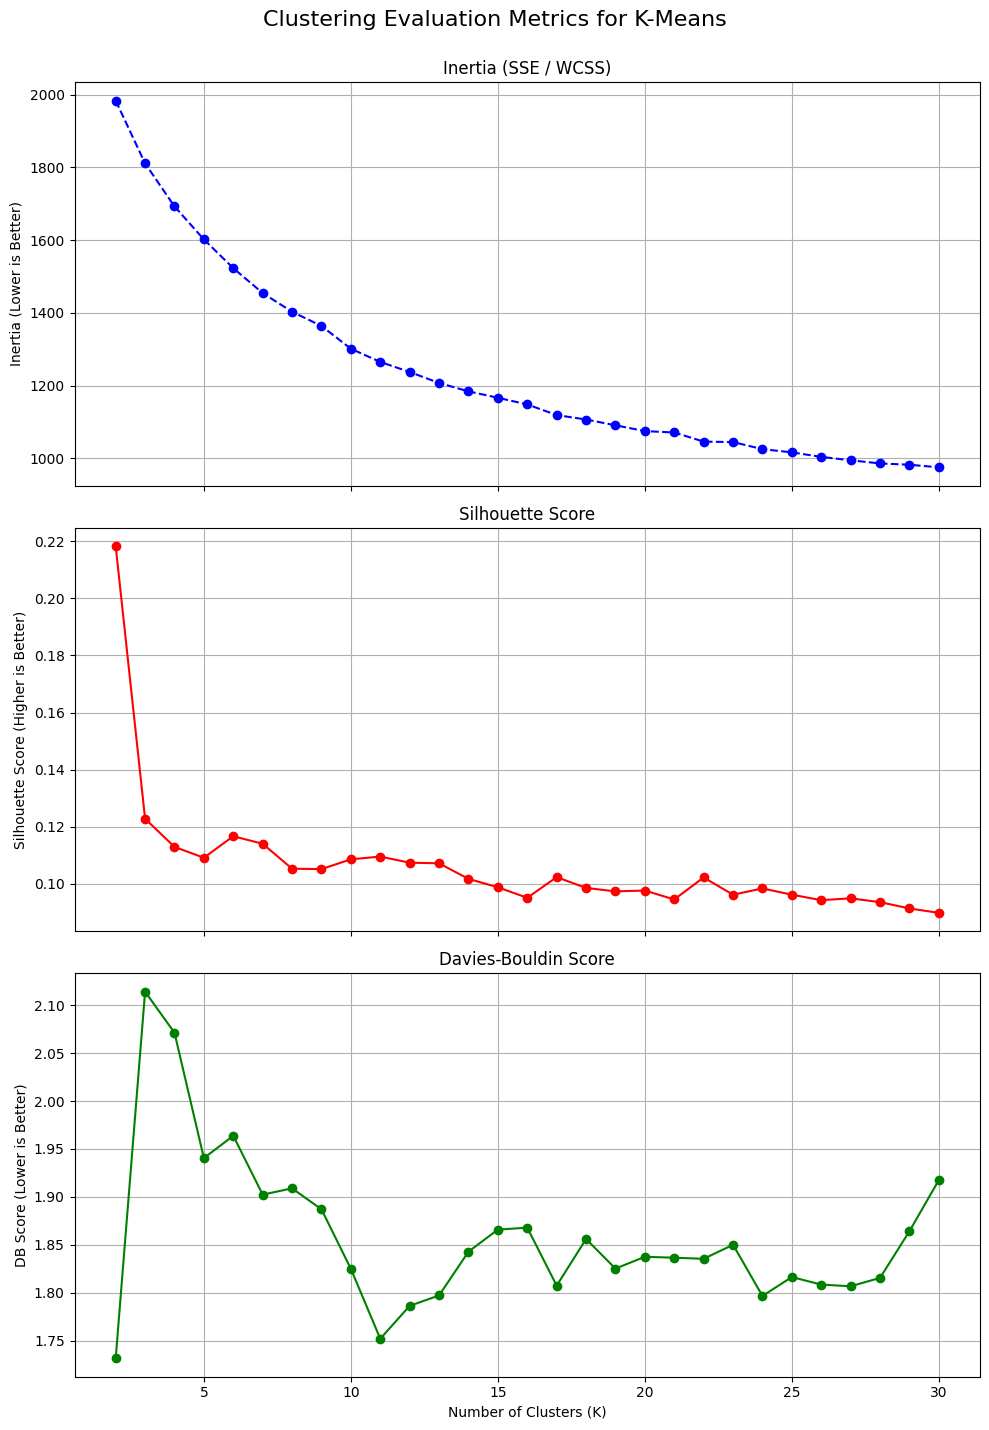

In [ ]:
# --- Initialization ---

k_range = range(2, 31) 
inertia_values2 = []
silhouette_values2 = []
davies_bouldin_values2 = []

# --- Loop and Calculate Metrics ---

for k in k_range:
    # 1. Train K-Means
    # Using n_init='auto' is the modern standard, replacing n_init=10
    kmeans2 = KMeans(n_clusters=k, random_state=42, n_init='auto') 
    kmeans2.fit(X_scaled2)
    
    # Get the cluster labels for evaluation metrics
    labels = kmeans2.labels_
    
    # 2. Calculate Inertia (WCSS / SSE)
    inertia_values2.append(kmeans2.inertia_)
    
    # 3. Calculate Silhouette Score (Requires K >= 2)
    # The score is calculated on the scaled data (X_scaled2) and the labels
    silhouette_values2.append(silhouette_score(X_scaled2, labels))
    
    # 4. Calculate Davies-Bouldin Score (Requires K >= 2)
    davies_bouldin_values2.append(davies_bouldin_score(X_scaled2, labels))

# --- Plotting All Metrics ---

fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
fig.suptitle('Clustering Evaluation Metrics for K-Means', fontsize=16)

# 1. Inertia Plot (WCSS / SSE) - Lower is better (Elbow Method)
axes[0].plot(k_range, inertia_values2, marker='o', linestyle='--', color='blue')
axes[0].set_title('Inertia (SSE / WCSS)')
axes[0].set_ylabel('Inertia (Lower is Better)')
axes[0].grid(True)

# 2. Silhouette Score Plot - Higher is better
axes[1].plot(k_range, silhouette_values2, marker='o', linestyle='-', color='red')
axes[1].set_title('Silhouette Score')
axes[1].set_ylabel('Silhouette Score (Higher is Better)')
axes[1].grid(True)

# 3. Davies-Bouldin Score Plot - Lower is better
axes[2].plot(k_range, davies_bouldin_values2, marker='o', linestyle='-', color='green')
axes[2].set_title('Davies-Bouldin Score')
axes[2].set_ylabel('DB Score (Lower is Better)')
axes[2].set_xlabel('Number of Clusters (K)')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent suptitle overlap
plt.show()

In [ ]:
# --- STEP 4A: Train the final model ---
optimal_k2 =  7# Replace with the K you chose from the plot

kmeans_final2 = KMeans(n_clusters=optimal_k2, random_state=42, n_init=10)
kmeans_final2.fit(X_scaled2)

# --- STEP 4B: Assign the labels back to the original DataFrame ---

# Create a temporary Series with the cluster labels and the corresponding index
cluster_labels_series2 = pd.Series(kmeans_final2.labels_, index=original_indices)

# Assign the labels back to the main DataFrame
df['Cluster2'] = np.nan # Initialize the column with NaN
df.loc[original_indices, 'Cluster2'] = cluster_labels_series2

# Convert the Cluster2 column to a category or Int64
df['Cluster2'] = df['Cluster2'].astype('Int64')

print(f"\n✅ Clustering complete! Data is grouped into {optimal_k2} clusters.")
print(df['Cluster2'].value_counts(dropna=False))


✅ Clustering complete! Data is grouped into 7 clusters.
Cluster2
<NA>    3683
0       1541
3       1322
2       1238
6       1205
4       1110
1        807
5        260
Name: count, dtype: Int64


In [ ]:
print('SSE %s' % kmeans_final2.inertia_) # cohesion, lower value better clustering (error minimization)
print('Separation %s' % davies_bouldin_score(X_scaled2, kmeans_final2.labels_)) # lower value, better clustering (minimum zero)
print('Silhouette %s' % silhouette_score(X_scaled2, kmeans_final2.labels_))

SSE 1454.2861779133236
Separation 1.9023178789522501
Silhouette 0.1140019073739541


In [ ]:
# Analyze the cluster centroids using the original feature names
cluster_profiles2 = df.groupby('Cluster2')[FEATURE_COLS].mean()

print("\n--- Cluster Profile Analysis (Mean Feature Values) ---")
print(cluster_profiles2.T)


--- Cluster Profile Analysis (Mean Feature Values) ---
Cluster2                                   0              1              2  \
tokens_per_sent                     8.601685       8.257015       8.908991   
avg_token_per_clause                7.356866       7.335656       7.442465   
swear_rate                          0.006185       0.004202       0.005858   
tokens_per_minute                  162.62267     123.257825     154.134462   
n_sentences                        63.181226       49.43295      62.774878   
n_tokens                          534.739074      398.63857     528.238173   
swear_IT                            2.677482       1.495663       2.482229   
swear_EN                            0.650876       0.340768       0.652666   
lexical_density                     0.512482       0.503815       0.505551   
bpm                                 91.28538     118.030458     101.360654   
centroid                            0.146914       0.108047       0.138918   
rolloff 

In [ ]:
scaled_centroids2 = kmeans_final2.cluster_centers_

# 3. Convert the NumPy array of scaled centroids into a DataFrame
scaled_cluster_profiles2 = pd.DataFrame(
    scaled_centroids2,
    columns=FEATURE_COLS2 # Use the original feature names
)

# 4. Add the 'Cluster' ID column
scaled_cluster_profiles2['Cluster2'] = scaled_cluster_profiles2.index.values.astype(int)

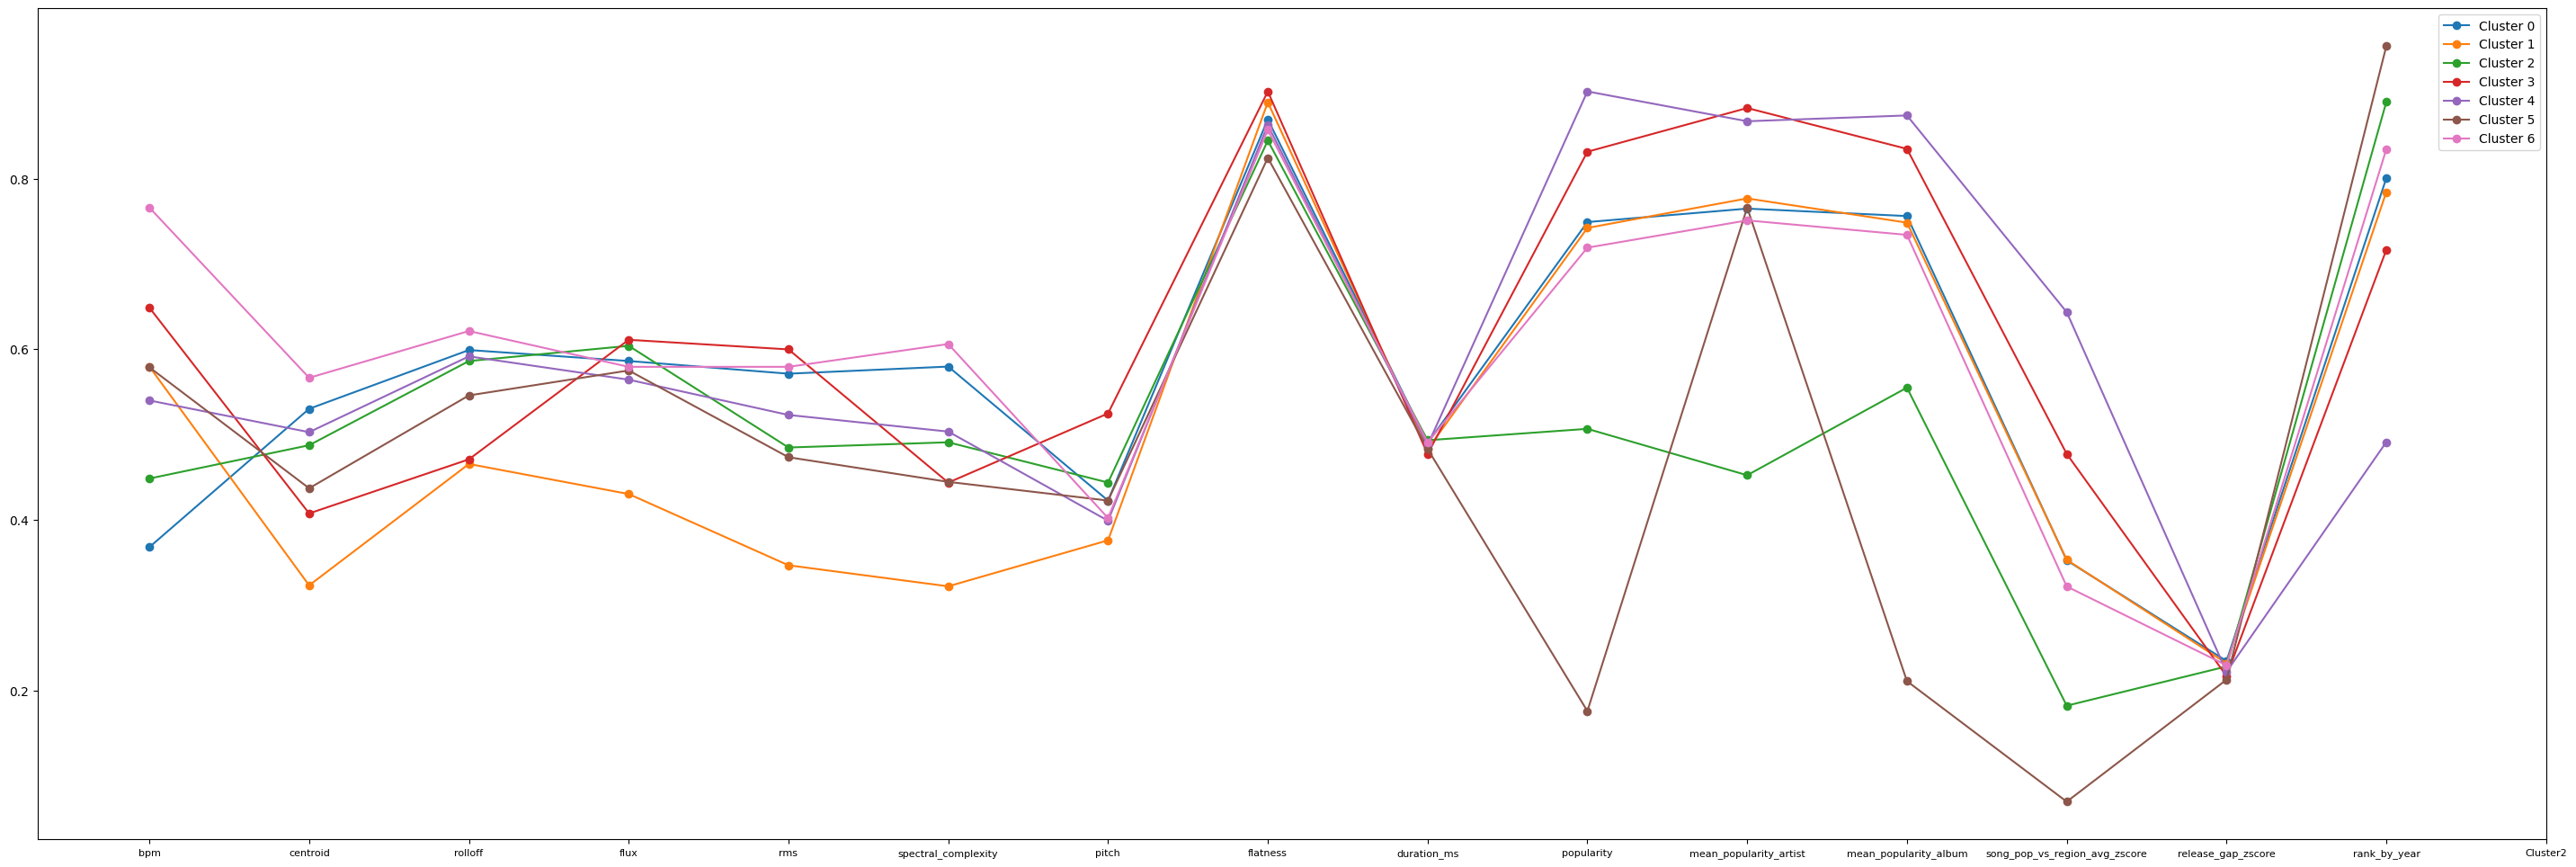

In [ ]:
plt.figure(figsize=(36, 12))
for i in range(0, len(scaled_centroids2)):
    plt.plot(scaled_centroids2[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(scaled_cluster_profiles2.columns)), scaled_cluster_profiles2.columns, fontsize=8)
plt.legend(fontsize=10)
plt.show()

In [ ]:
# 1. Get the scaled data and the corresponding cluster labels
# Assuming X_scaled contains your scaled features and 'Cluster' is assigned to df

# Drop rows where cluster assignment failed (due to missing values in the original features)
clustered_df2 = df.dropna(subset=['Cluster2']).copy()
X_scaled_clustered2 = MinMaxScaler().fit_transform(clustered_df2[FEATURE_COLS2])
cluster_labels2 = clustered_df2['Cluster2'].astype(int) # Ensure labels are integer

# 2. Initialize and run PCA to reduce the data to 2 components
pca2 = PCA(n_components=2)
principal_components2 = pca2.fit_transform(X_scaled_clustered2)

# 3. Create a DataFrame for plotting
pca_df2 = pd.DataFrame(
    data=principal_components2, 
    columns=['PC1', 'PC2']
)

# Add the cluster labels back to the plotting DataFrame
pca_df2['Cluster2'] = cluster_labels2.values

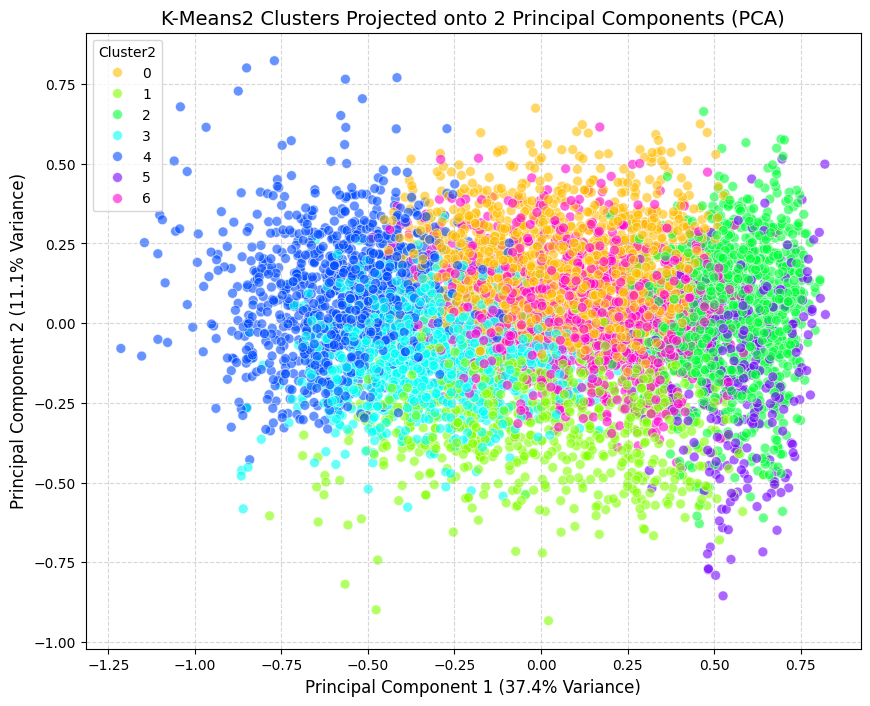

In [ ]:
plt.figure(figsize=(10, 8))

# Use seaborn scatterplot, coloring points by the 'Cluster' column
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='Cluster2', 
    data=pca_df2,
    palette=sns.color_palette("hsv", n_colors=pca_df2['Cluster2'].nunique()), # Use distinct colors
    legend="full",
    alpha=0.6,
    s=50
)

plt.title('K-Means2 Clusters Projected onto 2 Principal Components (PCA)', fontsize=14)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% Variance)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% Variance)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# Example: Analyzing the 'explicit' (binary) and 'region' (categorical) columns

EXTERNAL_CATEGORICAL_COLS = ['explicit', 'region', 'gender']

for col in EXTERNAL_CATEGORICAL_COLS:
    # 1. Calculate the raw counts
    cross_tab = pd.crosstab(df['Cluster'], df[col])
    
    # 2. Convert counts to proportions (percentage of the cluster)
    proportions = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
    
    print(f"\n--- PROPORTIONS OF {col.upper()} BY CLUSTER ---")
    print(proportions.round(1))


--- PROPORTIONS OF EXPLICIT BY CLUSTER ---
explicit  False  True 
Cluster               
0          27.3   72.7
1          32.0   68.0
2          27.1   72.9
3          28.4   71.6
4          25.9   74.1
5          47.1   52.9

--- PROPORTIONS OF REGION BY CLUSTER ---
region   Calabria  Campania  Emilia-Romagna  Lazio  Liguria  Lombardia  \
Cluster                                                                  
0             3.0      12.5             0.0   15.5      0.9       39.9   
1             0.1      22.9             1.3   15.8      3.7       29.8   
2             0.1      14.0             1.0   14.9      4.0       34.9   
3             0.1      16.8             2.4   17.1      5.5       28.8   
4             1.4      11.4             1.0    7.9      7.5       36.3   
5             0.4      25.0             2.2    9.6      2.7       32.3   

region   Marche  Piemonte  Puglia  Sardegna  Sicilia  Toscana  Veneto  
Cluster                                                          

/tmp/ipykernel_328946/1869617619.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Cluster ID')


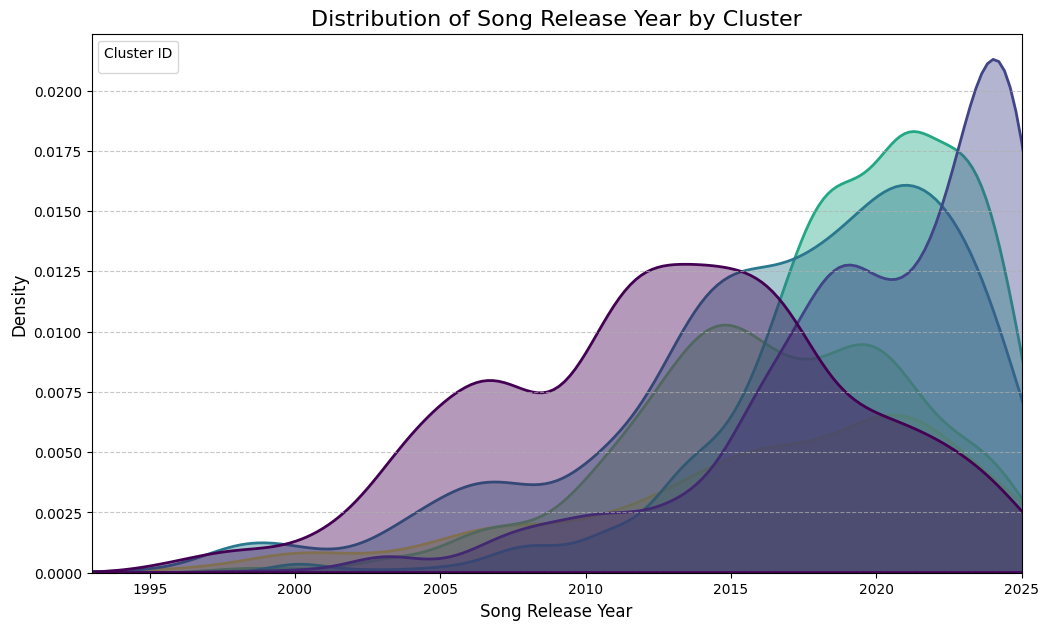

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Ensure the 'Cluster' column is integer type and we have the release date
# Drop NaNs in Cluster and correct_release_date for clean plotting
plot_df = df.dropna(subset=['Cluster', 'correct_release_date']).copy()
plot_df['Cluster'] = plot_df['Cluster'].astype(int)

# 2. Extract the year from the datetime object
plot_df['Release_Year'] = plot_df['correct_release_date'].dt.year

# --- Create the Plot ---
plt.figure(figsize=(12, 7))

# Use a density plot (kdeplot) to smooth the year distribution for each cluster
sns.kdeplot(
    data=plot_df, 
    x='Release_Year', 
    hue='Cluster', 
    fill=True, 
    palette='viridis', # Good for distinguishing multiple lines
    alpha=0.4,
    linewidth=2
)

plt.title('Distribution of Song Release Year by Cluster', fontsize=16)
plt.xlabel('Song Release Year', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xlim(plot_df['Release_Year'].min(), plot_df['Release_Year'].max()) # Set axis limits to relevant range
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Cluster ID')
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# 1. Prepare the DataFrame
# Drop rows with missing cluster assignment, release date, or active start date
analysis_df = df.dropna(subset=['Cluster', 'correct_release_date', 'active_start']).copy()

# Ensure Cluster column is integer type
analysis_df['Cluster'] = analysis_df['Cluster'].astype(int)

# 2. Extract Year and Month from date columns
analysis_df['Release_Year'] = analysis_df['correct_release_date'].dt.year
analysis_df['Release_Month'] = analysis_df['correct_release_date'].dt.month
analysis_df['Active_Start_Year'] = analysis_df['active_start'].dt.year

# 3. Group by Cluster and calculate the mean of the extracted values
average_dates = analysis_df.groupby('Cluster').agg(
    Mean_Release_Year=('Release_Year', 'mean'),
    Mean_Release_Month=('Release_Month', 'mean'),
    Mean_Active_Start_Year=('Active_Start_Year', 'mean') 
).reset_index()

# 4. Format the output table for readability
average_dates['Mean_Release_Year'] = average_dates['Mean_Release_Year'].round(1)
average_dates['Mean_Release_Month'] = average_dates['Mean_Release_Month'].round(1)
average_dates['Mean_Active_Start_Year'] = average_dates['Mean_Active_Start_Year'].round(1)

average_dates.rename(columns={
    'Mean_Release_Year': 'Avg_Song_Release_Yr',
    'Mean_Release_Month': 'Avg_Song_Release_Mo',
    'Mean_Active_Start_Year': 'Avg_Artist_Start_Yr'
}, inplace=True)


print("--- Average Release Timelines by Cluster ---")
print(average_dates)

--- Average Release Timelines by Cluster ---
   Cluster  Avg_Song_Release_Yr  Avg_Song_Release_Mo  Avg_Artist_Start_Yr
0        0               2013.0                  5.8               1999.3
1        1               2019.9                  6.6               2007.1
2        2               2016.7                  5.7               2004.7
3        3               2019.4                  6.3               2008.0
4        4               2016.3                  5.9               2003.6
5        5               2016.2                  5.7               2004.1


## Hierarchical

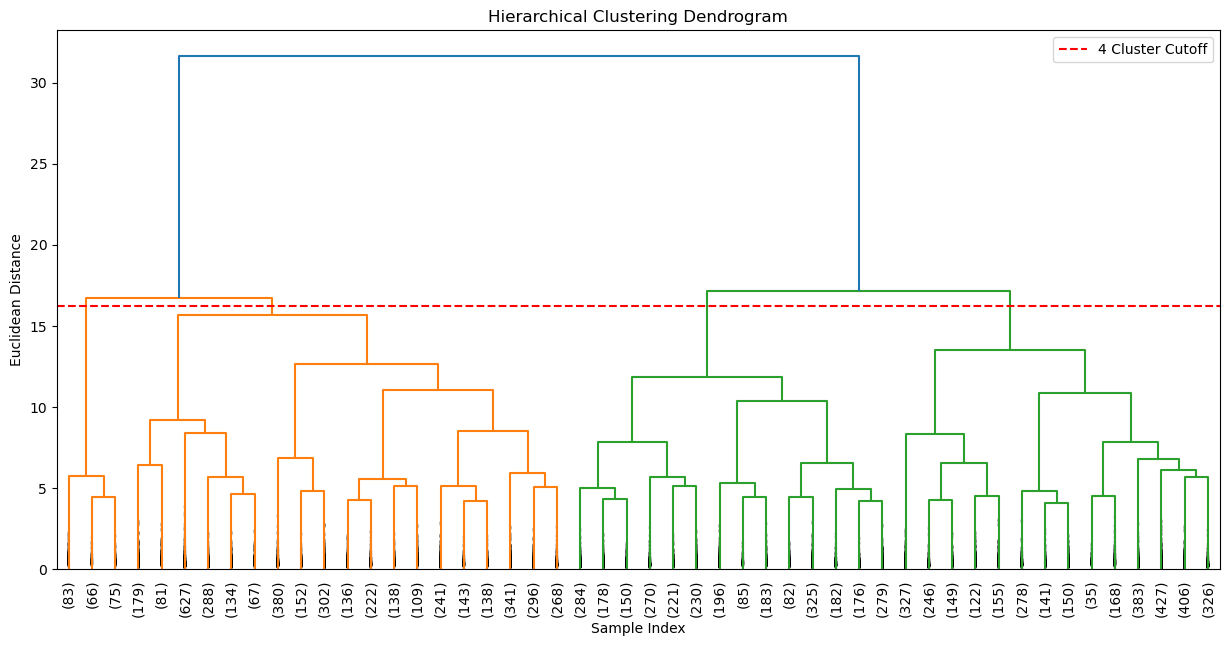

In [377]:
# 1. Compute the Linkage Matrix
# 'ward' minimizes the variance of the clusters being merged.
Z = linkage(X_scaled, method='ward')

# 2. Plot the Dendrogram
plt.figure(figsize=(15, 7))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Euclidean Distance")

dendrogram(
    Z,
    truncate_mode='lastp', 
    p=50,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True
)

# AGGIUNGI QUESTA RIGA
# Disegna una riga orizzontale all'altezza dove si formano 4 cluster
# Guardando il grafico, sembra che un taglio intorno a y=100 o 110 intersechi 4 linee verticali
plt.axhline(y=16.2, color='r', linestyle='--', label='4 Cluster Cutoff') 

plt.legend()
plt.show()

In [235]:
# --- CONFIGURATION ---
# Set this to the same K you used in K-Means for direct comparison
N_CLUSTERS = 4  # Change this to your chosen number

# 3. Fit the model
hc = AgglomerativeClustering(n_clusters=N_CLUSTERS, metric='euclidean', linkage='ward')
hc_labels = hc.fit_predict(X_scaled)

# 4. Assign labels back to your subset dataframe
data_for_clustering['cluster_hc'] = hc_labels

# 5. Map labels back to the original main DataFrame (df)
# We use the index mask we saved earlier to ensure alignment
df.loc[original_indices, 'cluster_hc'] = hc_labels

In [236]:
print(f"--- Hierarchical Clustering Results (k={N_CLUSTERS}) ---")

# Calculate Metrics
sil_score_hc = silhouette_score(X_scaled, hc_labels)
db_score_hc = davies_bouldin_score(X_scaled, hc_labels)

print(f"Silhouette Score:       {sil_score_hc:.4f} (Closer to 1 is better)")
print(f"Davies-Bouldin Score:   {db_score_hc:.4f} (Closer to 0 is better)")

--- Hierarchical Clustering Results (k=4) ---
Silhouette Score:       0.0731 (Closer to 1 is better)
Davies-Bouldin Score:   2.5370 (Closer to 0 is better)


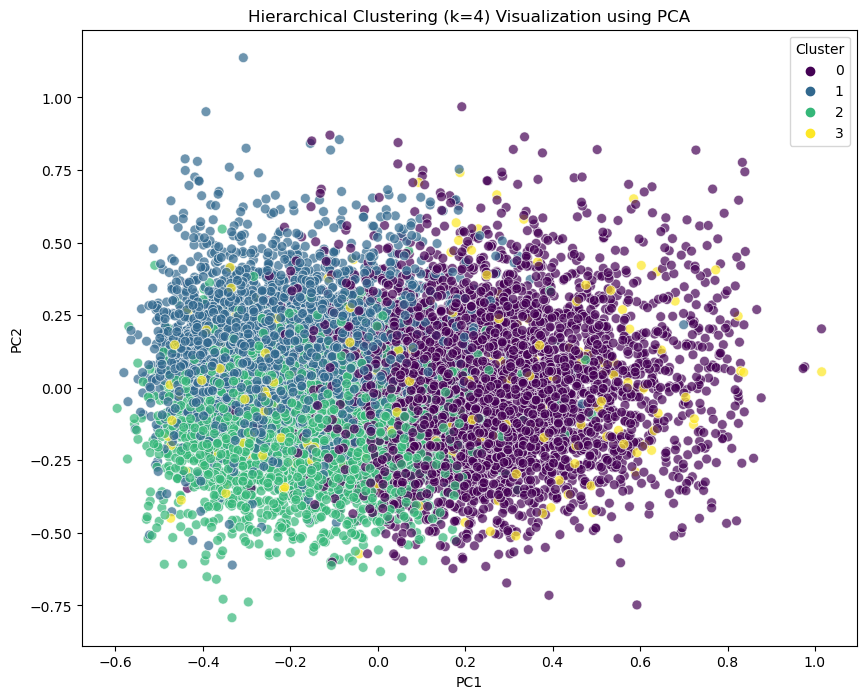

In [237]:
# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a temporary dataframe for plotting
df_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_plot['Cluster'] = hc_labels

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='Cluster', 
    data=df_plot, 
    palette='viridis', 
    s=50, 
    alpha=0.7
)
plt.title(f'Hierarchical Clustering (k={N_CLUSTERS}) Visualization using PCA')
plt.show()